# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import multivariate_normal, uniform
import random
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity

# Plot Decision Boundaries

In [3]:
def plotDecBoundaries_Nonlinear(labels, 
                                predictor,
                                mean_S1 = None,
                                mean_S2 = None,
                                kdensity_1 = None,
                                kdensity_2 = None,
                                fsize=(6,4), 
                                legend_on = False,
                                title = ""):
    
    '''
    Plot the decision boundaries and data points for any binary classifiers
    
    feature: origianl2D feautre, N x 2 array:
        N: number of data points
        2: number of features 
    labels: class lables correspond to feature, N x 1 array: [0,0,1,1,0,0,...]
        N: number of data points
    legend_on: add the legend in the plot. potentially slower for datasets with large number of clases and data points
    ----------------------------
    You need to write the following two functions
    non_linear_trans: your custom non-linear transforation function.
        <feature_nonlinear> = non_linear_trans(<feature_original>), 
            Input: <feature_original>, Nx2 array, 
            Output: <feature_nonlinear>: Nx? array.
        if no nonlinear transformation performs, then, 
        let non_linear_trans = lambda x:x, which just output your original feature
    
    predictor: your custom predictor.
        <predictions> = predictor(<feature>)
            Input: <feature> Nx? array.
            Output: <predictions> binary labels, i.e., array ([0,1,0,0,1...])
    If you don't want write custom functions, you can modify this plot function based on your need,
    do non-linear transformation and class prediction inside this plot function.
    ----------------------------
    '''

    labels = labels.astype(int)

    # Set the feature range for ploting
    # max_x = np.ceil(max(feature[:, 0])) + 1
    # min_x = np.floor(min(feature[:, 0])) - 1
    # max_y = np.ceil(max(feature[:, 1])) + 1
    # min_y = np.floor(min(feature[:, 1])) - 1

    # Bounds of plot
    xrange = (-8, 4)
    yrange = (-6, 6)

    # step size for how finely you want to visualize the decision boundary.
    inc = 0.05

    # generate grid coordinates. this will be the basis of the decision
    # boundary visualization.
    (x, y) = np.meshgrid(np.arange(xrange[0], xrange[1]+inc/100, inc), np.arange(yrange[0], yrange[1]+inc/100, inc))

    # size of the (x, y) image, which will also be the size of the
    # decision boundary image that is used as the plot background.
    image_size = x.shape
    xy = np.hstack( (x.reshape(x.shape[0]*x.shape[1], 1, order='F'), y.reshape(y.shape[0]*y.shape[1], 1, order='F')) ) # make (x,y) pairs as a bunch of row vectors.
    
    '''
    You should write the custom functions, non_linear_trans and predictor
    '''
    # apply non-linear transformation to all points in the map (not only data points)
    # xy = non_linear_trans(xy)
    # predict the class of all points in the map 
    if kdensity_1 and kdensity_2: 
      pred_label = predictor(xy, kdensity_1, kdensity_2)
    else:
      pred_label = predictor(xy)

    # reshape the idx (which contains the class label) into an image.
    decisionmap = pred_label.reshape(image_size, order='F')

    # documemtation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    symbols_ar = np.array(['rx', 'bo', 'ms', 'cd','gp','y*','kx','gP','r+','bh'])
    #show the image, give each coordinate a color according to its class label
    plt.figure(figsize=fsize)

    plt.imshow(decisionmap, extent=[xrange[0], xrange[1], yrange[0], yrange[1]], origin='lower', aspect='auto')

    # plot the class data.
    # plot_index = 0
    # class_list = []
    # class_list_name = [] #for legend
    # for cur_label in np.unique(labels):
    #     # print(cur_label,plot_index,np.sum(label_train == cur_label))
    #     d1, = plt.plot(feature[labels == cur_label, 0],feature[labels == cur_label, 1], symbols_ar[plot_index])

    #     if legend_on:
    #         class_list.append(d1)
    #         class_list_name.append('Class '+str(plot_index))
    #         l = plt.legend(class_list,class_list_name, loc=2)
    #         plt.gca().add_artist(l)
       
    #     plot_index = plot_index + 1

    # Means of the three densities (2 means in S1, 1 mean in S2).
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    if mean_S1 and mean_S2:
      plt.scatter(mean_S1[0], mean_S1[1], label = "S1")
      plt.scatter(mean_S2[0], mean_S2[1], label = "S2")

    plt.show()

# Q2: 2-class minimum-error classification based on KDE estimates

In [4]:
# Defining mean and covariance
# First class
mean_1 = np.array([-4, 0])
covariance_1 = np.array([[4, 0], [0, 1]])

# Second class
mean_2 = np.array([-0.5, 0])
covariance_2 = np.array([[0.16, 0], [0, 9]])


## Predictor

- p2(x) = Ux1(0,2)Ux2(−1,1)
- p1(x) = N(x|m1, Σ1)
- p(x|S1) = α1p1(x) + α2p2(x)
- p(x|S2) = N(x|m2, Σ2)


In [5]:
def predictor(x):
  # a1, a2, S1, S2
  a1 = 0.7
  a2 = 0.3
  pS1 = pS2 = 0.5

  predictions = []

  for point in x:
    # calculate p1(x)
    p1 = multivariate_normal.pdf(point, mean_1, covariance_1)
    
    # Calculate p2(x)
    p2 = uniform.pdf(point[0], loc = 0, scale = 2) * uniform.pdf(point[1], loc = -1, scale = 1)
    
    # Calculate p(x|S1)
    px_s1 = (a1 * p1 + a2 * p2) * pS1

    # Calculate p(x|S2)
    px_s2 = multivariate_normal.pdf(point, mean_2, covariance_2) * pS2
    
    # Classify based on densities
    if px_s1 > px_s2:
      predictions.append(1)
    else:
      predictions.append(2)
    
  return np.array(predictions)
    
# Uniform() found in https://scipy.github.io/devdocs/reference/generated/scipy.stats.uniform.html

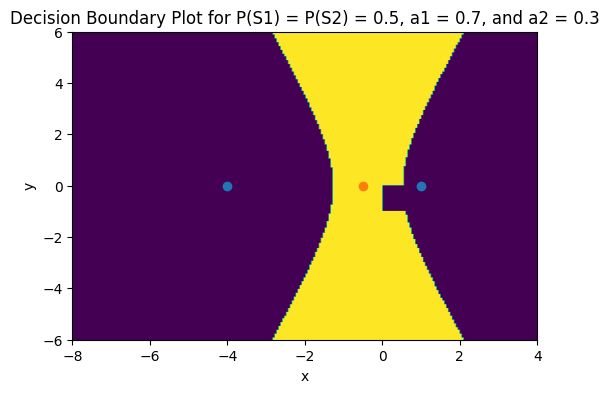

In [6]:
plotDecBoundaries_Nonlinear(np.array([1, 2]), 
                            predictor,
                            mean_S1 = [[-4, 1], [0,0]], # x, y
                            mean_S2 = [[-0.5], [0]], # x, y
                            title = "Decision Boundary Plot for P(S1) = P(S2) = 0.5, a1 = 0.7, and a2 = 0.3")

## Dataset generation.
Draw and store N = 20,000 data points from p(x, Sk), in a 20,000 × 3 matrix (the 3 columns are x1, x2, k). This is the “full training dataset”, and your training datasets below
will come from this. (No need to report anything.)
Separately, draw and store Ntest = 10,000 data points from p(x, sk), in a 10,000 × 3
matrix. This will be your testing set. (No need to report anything.)
Tips:
For the normal densities, use np.random.multivariate_normal.
For p(x, Sk), you can draw each data point by first drawing randomly between S1
and S2 according to P(S1), then draw from p(x|S1) or p(x|S2). 

Similarly, to draw from P(X|S1) you can first draw randomly a value of 1 (with
probability 0.7) or 2 (with probability 0.3) (biased coin flip). If 1 was drawn, then
draw x from p1(x) if 2 was drawn, then draw x from p2(x). 

In [7]:
def generate_data(rows):
  pS1 = pS2 = 0.5
  a1 = 0.7
  a2 = 0.3

  # rows x 3 matrix
  data = []

  ''' Populating Rows '''
  for i in range(rows):
    row = []
    # Deciding Label
    label = np.random.choice([1, 2], p = [pS1, pS2])
    
    # if label is 1 then pull from p(x|S1)
    if label == 1:
      temp = np.random.choice([1, 2], p = [a1, a2])
      if temp == 1:
        row = np.random.multivariate_normal(mean_1, covariance_1).tolist()
      else:
        row = [np.random.uniform(0, 2),
               np.random.uniform(-1, 1)]
    # else pull from p(x|S2)
    else:
      row = np.random.multivariate_normal(mean_2, covariance_2).tolist()

    row.append(label)

    data.append(row)
  
  return np.array(data)

In [8]:
train = generate_data(20000)
test = generate_data(10000)

To visualize the data, produce a scatter plot in 2D feature space of the first 2000 points in
the full training set, with a different symbol or color for each class. 

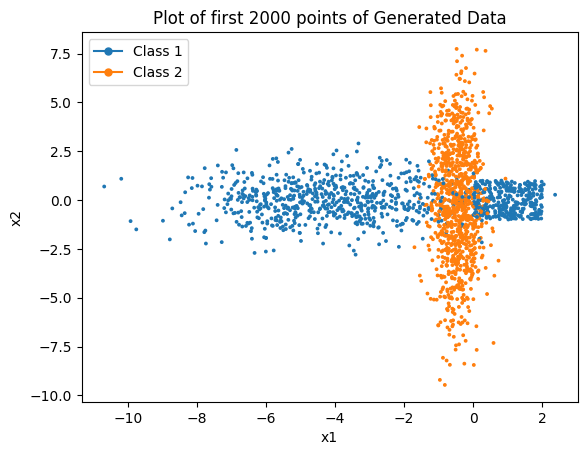

In [9]:
data = train[:2000, :] # First 2000 points
scatter = plt.scatter(data[:, 0], data[:, 1], c = data[:, 2], s = 3,
            cmap = mcolors.ListedColormap(["C0", "C1"]))
plt.title("Plot of first 2000 points of Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
class_labels = ["Class 1", "Class 2"]
legend_elements = [plt.Line2D(xdata = [0], 
                              ydata = [0], 
                              marker='o', 
                              markersize=5, 
                              color=c) for c in scatter.cmap([0, 1])]
plt.legend(legend_elements, class_labels)

## (c) Ideal accuracy.
Compute the classification accuracy of your classifier in (a) on the testing set. 

In [10]:
predicted_labels = predictor(test[:, :2])
accuracy_score(test[:, 2], predicted_labels)

0.9408

## (d) Minimum-error classifier based on estimates from the training data.
In this part your code will learn from the data without knowledge of the probabilities
given above.
Repeat this part for a training set Dn that uses the first n data points in the full training
dataset, for n = 200, 2000, 20000 (e.g., n=200 will result in 200 data points for D200, some of which will be labeled S1 and some of which will be labeled S2).
Use KDE to get estimates pn(x|S1) and pn(x|S2) of the class-conditional densities from
Dn. Use a Gaussian window function:
Φ(u) = exp (-0.5 ||u||^2) with u = x/hn
and kernel width (bandwidth) hn = (100 / n)^(1/4). (No need to report anything.)

(i) Use frequency of occurrence to estimate get estimates P(S1), 
P(S2) of the class
priors from Dn. (Report 2 values for each value of n)

(ii) Plot in 2D feature space the decision boundaries and decision regions for a Bayes
minimum-error classifier based on your KDE and prior estimates from Dn. (1 plot
for each value of n)

In [42]:
def predict_mec(x, kde_1, kde_2):
  exp_px1 = np.exp(kde_1.score_samples(x))
  exp_px2 = np.exp(kde_2.score_samples(x))
  return np.where(exp_px1 > exp_px2, 1, 2) # Weird notation here since exp_px1 and 2 are np.arrays themselves, faster and cleaner

def mec(n):
  # choose the first n rows of train data
  data = train[:n, :]

  # part i
  PS1 = data[data[:, 2] == 1].shape[0] / data.shape[0]
  PS2 = data[data[:, 2] == 2].shape[0] / data.shape[0]

  # Calculating Hn: bandwidth
  hn = (100 / n) ** (1/4)

  # Create KDE objects for each class
  kde_1 = KernelDensity(kernel = 'gaussian', bandwidth = hn)
  kde_1.fit(data[data[:, 2] == 1][:, :2]) # Fit features
  kde_2 = KernelDensity(kernel = 'gaussian', bandwidth = hn)
  kde_2.fit(data[data[:, 2] == 2][:, :2]) # Fit features

  # Plot
  plotDecBoundaries_Nonlinear(np.array([1,2]),
                            predict_mec,
                            kdensity_1 = kde_1,
                            kdensity_2 = kde_2,
                            title = f"N = {n} | Decision Boundary Plot for Bayes minimum-error classifier")
  
  return (n, kde_1, kde_2, PS1, PS2)

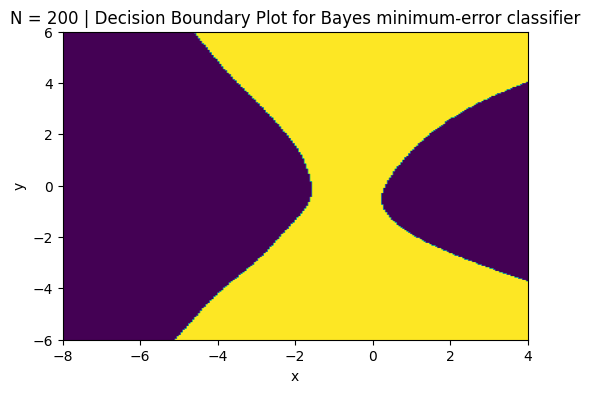

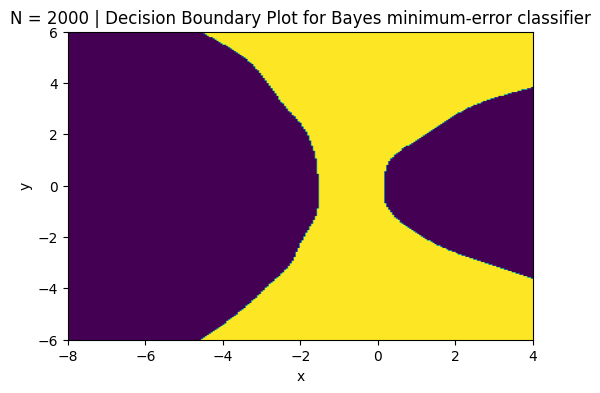

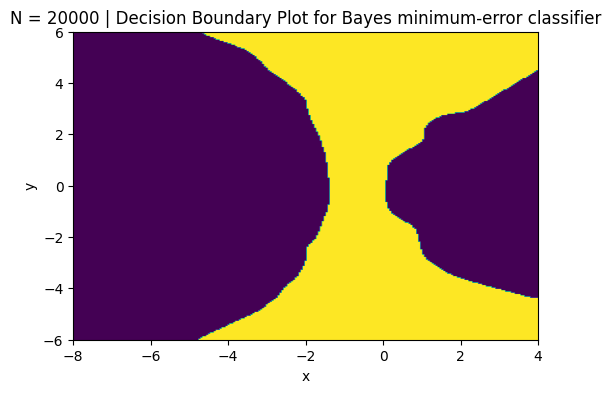

In [43]:
accuracies = []
for n in [200, 2000, 20000]:
  accuracies.append(mec(n))

(iii) Compute and report the classification accuracy on the testing set for the classifier
based on Dn. (1 accuracy for each value of n)

In [44]:
print("======= Accuracy for Bayes Minimum-Error Classifiers w/ Test Data ========")
for i in accuracies:
  predicted = predict_mec(test[:, :2], i[1], i[2])
  acc = accuracy_score(test[:, 2], predicted)
  print(f"N: {i[0]} | Accuracy = {acc} | P(S1) = {i[3]} | P(S2) = {i[4]}")

======= Accuracy for Bayes Minimum-Error Classifiers w/ Test Data ========
N: 200 | Accuracy = 0.9233 | P(S1) = 0.515 | P(S2) = 0.485
N: 2000 | Accuracy = 0.9438 | P(S1) = 0.5035 | P(S2) = 0.4965
N: 20000 | Accuracy = 0.9509 | P(S1) = 0.5004 | P(S2) = 0.4996
